In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import os
import sys
sys.path.append('/home/esther/qr_for_landcover/scripts')
import landcover_definitions as lc
import util
import pickle

In [6]:
torchgeo_data_dir = '/datadrive/esther/torchgeo_data'
torchgeo_preds_dir = '/home/esther/torchgeo_predictions_rep'

In [7]:
def reindex_cc(array_in):
    impervious_idxs_highres_orig = [4,5,6]
    impervious_idx_condensed = 4
    
    reindexed_array = array_in.copy()
    for c_idx in impervious_idxs_highres_orig:
        reindexed_array[array_in == c_idx] = impervious_idx_condensed
            
    return reindexed_array - 1

ignore_index = 4

In [8]:
np.arange(0,ignore_index)

array([0, 1, 2, 3])

In [11]:
set_this = 'test'
compute_r = True
results_by_state_q = {}
results_by_state_r = {}

states_to_eval = ['ny+pa',
                    'ny', 
                    'pa'
                 ]

loss_to_eval_options = ['qr_forward', 
                        'qr_reverse'
                       ]
                        

prior_version = 'from_cooccurrences_101_31_no_osm_no_buildings'
prior_name = f'prior_{prior_version}'
p_add_smooth = 1e-4
lc_type = 'chesapeake_4_no_zeros'
compute_r = True
for loss in loss_to_eval_options:
    results_by_state_q[loss] = {}
    results_by_state_r[loss] = {}
    
    for state_str in states_to_eval:

        data_dir = f'{torchgeo_data_dir}/cvpr_chesapeake_landcover'
        
        run_name = f'{state_str}_fcn_0.0001_{loss}_{prior_version}_additive_smooth_0.0001_prior_smooth_0.0001/'
               
        accs_q = []
        ious_q = []
        accs_r = []
        ious_r = []
        num_pix = []
        
        for state in state_str.split('+'):
            state_identifier = f'{state}_1m_2013_extended-debuffered-test_tiles'
            data_dir_this_set = os.path.join(data_dir,state_identifier)
            pred_dir = f'{torchgeo_preds_dir}/{run_name}/cvpr_chesapeake_landcover'
            pred_dir_this_set = os.path.join(pred_dir,state_identifier)
        
            fns = os.listdir(data_dir_this_set)
            tile_ids = np.unique([x[:17] for x in fns])
            
            print(len(tile_ids))
            
            for tile_id in tile_ids:
                fn_this = os.path.join(data_dir_this_set, f'{tile_id}_lc.tif')
                pred_fn_this = os.path.join(pred_dir_this_set, f'{tile_id}_{loss}_pred_last.tif')
                t1 = time.time()

                # gather the data
                with rasterio.open(fn_this) as f:
                    hr_lc = f.read()[0]
                # reindex
                hr_lc = reindex_cc(hr_lc)

                preds_this_soft = rasterio.open(pred_fn_this).read()

                preds_this = preds_this_soft.argmax(0)
                acc_this_q = (np.array([hr_lc == preds_this])[np.array([hr_lc!=ignore_index])]).mean()

                # ignore 0
                iou_this_q = util.per_class_iou(hr_lc, preds_this, np.arange(0,ignore_index))
                accs_q.append(acc_this_q)
                ious_q.append(iou_this_q)
                num_pix.append((hr_lc != ignore_index).sum())

                if compute_r:
                    # now do r
                    prior_this = rasterio.open(fn_this.replace('lc.tif',f'{prior_name}.tif')).read()

                    # first normalize
                    prior = prior_this / prior_this.sum(axis=0)
                    # now add smoothing and renormalize 

                    prior = (prior + p_add_smooth) / (prior + p_add_smooth).sum(axis=0)

                    # compute z and r
                    z = (preds_this_soft.T / preds_this_soft.sum(axis=(1,2)) ).T
                    preds_r = (prior*z).argmax(0)

                    acc_this_r = (np.array([hr_lc == preds_r])[np.array([hr_lc!=ignore_index])]).mean()
                    iou_this_r = util.per_class_iou(hr_lc, preds_r, np.arange(0,ignore_index))

                    accs_r.append(acc_this_r)
                    ious_r.append(iou_this_r)

                t2 = time.time()
                print(f'{t2-t1:.2f} seconds')

        ious_aggregated_q = util.aggregate_ious([x[1] for x in ious_q], [x[2] for x in ious_q])
        acc_aggregated_q = (np.array(accs_q) * np.array(num_pix)).sum() / np.sum(num_pix)
        print(f'For {state_str} {set_this} set with {loss} loss:')
        print(f'acc q: {acc_aggregated_q}')
        print(f'mean iou q: {np.mean(ious_aggregated_q[0])}')
        
        if compute_r:
            acc_aggregated_r = (np.array(accs_r) * np.array(num_pix)).sum() / np.sum(num_pix)
            ious_aggregated_r = util.aggregate_ious([x[1] for x in ious_r], [x[2] for x in ious_r])
            print(f'acc r: {acc_aggregated_r}')
            print(f'mean iou r: {np.mean(ious_aggregated_r[0])}')
        
        print('IoU per class over the tiles (q) is: ')
        print(ious_aggregated_q[0])
        if compute_r:
            print('IoU per class over the tiles (r) is: ')
            print(ious_aggregated_r[0])
        

        results_by_state_q[loss][state_str] = {'accs': accs_q,
                                           'ious': ious_q,
                                           'num_pix':num_pix,
                                           'ious_aggregated': ious_aggregated_q,
                                           'acc_aggregated':acc_aggregated_q}
        
        if compute_r:
            results_by_state_r[loss][state_str] = {'accs': accs_r,
                                               'ious': ious_r,
                                               'num_pix':num_pix,
                                               'ious_aggregated': ious_aggregated_r,
                                               'acc_aggregated':acc_aggregated_r}
        
#     out_fn = f'/home/esther/torchgeo_predictions/{run_name.replace("_"+state_str,"")}.pkl'
#     with open(out_fn, 'wb') as f:
#         print(f'writing results to {out_fn}')
#         pickle.dump({'results_by_state_q':results_by_state_q[loss],
#                      'results_by_state_r':results_by_state_r[loss]}, f)

20
6.30 seconds
6.32 seconds
6.28 seconds
6.23 seconds
6.26 seconds
6.27 seconds
6.22 seconds
6.24 seconds
6.18 seconds
6.26 seconds
6.23 seconds
6.44 seconds
6.43 seconds
6.44 seconds
6.37 seconds
6.52 seconds
6.53 seconds
6.21 seconds
6.35 seconds
6.35 seconds
20
6.60 seconds
6.82 seconds
6.78 seconds
6.73 seconds
6.71 seconds
6.99 seconds
6.94 seconds
6.74 seconds
6.66 seconds
6.25 seconds
6.35 seconds
6.45 seconds
6.58 seconds
6.64 seconds
6.58 seconds
6.69 seconds
6.66 seconds
6.77 seconds
6.69 seconds
6.78 seconds
For ny+pa test set with qr_forward loss:
acc q: 0.8599840909542062
mean iou q: 0.7032198448733731
acc r: 0.8660629836143582
mean iou r: 0.7183525223716636
IoU per class over the tiles (q) is: 
[0.8002972066242735, 0.8178920767032652, 0.6879671127610435, 0.5067229834049098]
IoU per class over the tiles (r) is: 
[0.8202728625872915, 0.8247966156856787, 0.6983476968352493, 0.529992914378435]
20
6.22 seconds
6.25 seconds
6.18 seconds
6.19 seconds
6.21 seconds
6.18 seconds
6

/tmp/ipykernel_19643/3640636260.py:81: RuntimeWarning: invalid value encountered in true_divide
  z = (preds_this_soft.T / preds_this_soft.sum(axis=(1,2)) ).T


6.61 seconds
6.77 seconds
6.74 seconds
6.60 seconds
6.57 seconds
6.75 seconds
6.80 seconds
6.79 seconds
6.60 seconds
6.22 seconds
6.35 seconds
6.42 seconds
6.41 seconds
6.54 seconds
6.48 seconds
6.59 seconds
6.79 seconds
6.86 seconds
6.91 seconds
6.93 seconds
For pa test set with qr_reverse loss:
acc q: 0.7581165075296211
mean iou q: 0.3267420377232626
acc r: 0.016600141353935994
mean iou r: 0.0041500353384839985
IoU per class over the tiles (q) is: 
[0.0, 0.7513870552857294, 0.4756781348264246, 0.07990296078089637]
IoU per class over the tiles (r) is: 
[0.016600141353935994, 0.0, 0.0, 0.0]


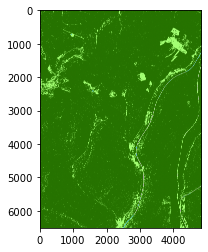

In [12]:
# visualize an example of the predictions
plt.imshow(lc.vis_lc(preds_this_soft,lc_type).T.swapaxes(0,1))

# compile in table format

In [14]:
0

0

In [17]:
states_in_reporting_order = [#'pa', #'ny', 
    'ny+pa']

for loss in ['qr_forward','qr_reverse']:
    print(loss + " q ")
    
    result_str = ""
    for state in states_in_reporting_order:
    
        results_q = results_by_state_q[loss][state]
        
        result_str += f"& {np.round(results_q['acc_aggregated']*100,1):.01f} "
        result_str += f"& {np.round(np.mean(results_q['ious_aggregated'][0])*100,1):.01f} "
        
    print(result_str)
    
    print(loss + " r ")
    
    result_str = ""
    for state in states_in_reporting_order:
    
        results_r = results_by_state_r[loss][state]
        
        result_str += f"& {np.round(results_r['acc_aggregated']*100,1):.01f}  "
        result_str += f"& {np.round(np.mean(results_r['ious_aggregated'][0])*100,1):.01f} "
        
    print(result_str)
    

qr_forward q 
& 86.0 & 70.3 
qr_forward r 
& 86.6  & 71.8 
qr_reverse q 
& 79.2 & 61.9 
qr_reverse r 
& 79.2  & 62.1 


In [7]:
states_in_reporting_order = [#'pa', #'ny', 
    'ny+pa']

for loss in ['qr_forward','qr_reverse']:
    print(loss + " q ")
    
    result_str = ""
    for state in states_in_reporting_order:
    
        results_q = results_by_state_q[loss][state]
        
        result_str += f"& {np.round(results_q['acc_aggregated']*100,2):.02f} "
        result_str += f"& {np.round(np.mean(results_q['ious_aggregated'][0])*100,2):.02f} "
        
    print(result_str)
    
    print(loss + " r ")
    
    result_str = ""
    for state in states_in_reporting_order:
    
        results_r = results_by_state_r[loss][state]
        
        result_str += f"& {np.round(results_r['acc_aggregated']*100,2):.01f}  "
        result_str += f"& {np.round(np.mean(results_r['ious_aggregated'][0])*100,2):.021f} "
        
    print(result_str)
    

qr_forward q 
& 84.20 & 66.57 & 86.20 & 70.96 & 84.62 & 67.67 
qr_forward r 
& 84.99  & 68.10 & 86.90  & 72.42 & 85.40  & 69.39 
qr_reverse q 
& 82.24 & 63.37 & 78.96 & 61.44 & 78.69 & 59.38 
qr_reverse r 
& 82.27  & 63.51 & 79.02  & 61.61 & 78.76  & 59.65 
